# DECOMON tutorial #4 
## Local Robustness to Brightness perturbations

## Introduction

After training a model, we want to make sure that the model will give the same output for any images "close" to the initial one, showing some robustness to perturbation. 

In this notebook, we start from a classifier built on MNIST dataset that given a hand-written digit as input will predict the digit. This will be the first part of the notebook.

<img src="./data/Plot-of-a-Subset-of-Images-from-the-MNIST-Dataset.png" alt="examples of hand-written digit" width="600"/>

In the second part of the notebook, we will investigate the robustness of this model to unstructured modification of the input space: adversarial attacks. For this kind of attacks, **we vary the magnitude of the perturbation of the initial image** and want to assess that despite this noise, the classifier's prediction remain unchanged.

<img src="./data/illustration_adv_attacks.jpeg" alt="examples of hand-written digit" width="600"/>

What we will show is the use of decomon module to assess the robustness of the prediction towards noise.

## The notebook

### imports

In [1]:
import os
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from ipywidgets import interact, interactive, fixed, interact_manual
from ipykernel.pylab.backend_inline import flush_figures
import ipywidgets as widgets
import time
import sys
sys.path.append('..')
import os.path
import os
import pickle as pkl
from contextlib import closing
import time

### load images

We load MNIST data from keras datasets. 


In [2]:
img_rows, img_cols = 28, 28
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.
y_train = keras.utils.to_categorical(y_train_)
y_test = keras.utils.to_categorical(y_test_)

### learn the model (classifier for MNIST images)

For the model, we use a small fully connected network. It is made of 6 layers with 100 units each and ReLU activation functions. **Decomon** is compatible with a large set of Keras layers, so do not hesitate to modify the architecture.

In [3]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=784))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [4]:
model.compile('adam', 'categorical_crossentropy', metrics='acc')

model.fit(x_train, y_train, batch_size=32, shuffle=True, validation_split=0.2, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4873 - acc: 0.8588 - val_loss: 0.1398 - val_acc: 0.9578
Epoch 2/5
1500/1500 [==============================] - 1s 915us/step - loss: 0.1207 - acc: 0.9624 - val_loss: 0.1187 - val_acc: 0.9642
Epoch 3/5
1500/1500 [==============================] - 1s 889us/step - loss: 0.0784 - acc: 0.9755 - val_loss: 0.1014 - val_acc: 0.9693
Epoch 4/5
1500/1500 [==============================] - 1s 942us/step - loss: 0.0608 - acc: 0.9808 - val_loss: 0.1085 - val_acc: 0.9659
Epoch 5/5
1500/1500 [==============================] - 1s 887us/step - loss: 0.0459 - acc: 0.9848 - val_loss: 0.0971 - val_acc: 0.9716


In [5]:
model.evaluate(x_test, y_test, batch_size=32)

313/313 [==============================] - 0s 893us/step - loss: 0.0996 - acc: 0.9702


[0.09956111013889313, 0.9702000021934509]

After training, we see that the assessment of performance of the model on data that was not seen during training shows pretty good results: around 0.97 (maximum value is 1). It means that out of 100 images, the model was able to guess the correct digit for 97 images. But how can we guarantee that we will get this performance for images different from the ones in the test dataset? 

- If we perturbate a "little" an image that was well predicted, will the model stay correct? 
- Up to which perturbation?  
- Can we guarantee that the model will output the same digit for a given perturbation? 

This is where decomon comes in. 

<img src="./data/decomon.jpg" alt="Decomon!" width="400"/>

### Applying Decomon for Local Robustness to misclassification

In this section, we detail how to prove local robustness to misclassification due to some environmental condition: **Brightness (Luminosity)**. Misclassification can be studied with the global optimisation of a function f:

$$ f(x; \Omega) = \max_{z\in \Omega} \text{NN}_{j\not= i}(z) - \text{NN}_i(z)\;\; \text{s.t}\;\; i = argmax\;\text{NN}(x)$$

If the maximum of f is **negative**, this means that whathever the input sample from the domain, the value outputs by the neural network NN for class i will always be greater than the value output for another class. Hence, there will be no misclassification possible. This is **adversarial robustness**.

<img src="./data/tuto_3_formal_robustness.png" alt="Decomon!" width="400"/>

In that order, we will use the [decomon](https://gheprivate.intra.corp/CRT-DataScience/decomon/tree/master/decomon) library. Decomon combines several optimization trick, including linear relaxation
to get state-of-the-art outer approximation.

To use **decomon** for **brightness robustness** we first need the following imports:
+ *from decomon.models import clone*: to clone our current Keras model into another neural network nn_model. nn_model will output the same prediction that our model and adds extra information that will be used to derive our formal bounds. For a sake of clarity, how to get such bounds is hidden to the user. Note that we presented in the previous tutorials another method for converting into decomon that we denote *convert*. You can use the *convert* method as well but due to some extra information carried out with the *clone* method, we will get better results.

+ *from decomon.applications.cv import get_adv_box*: a genereric method to get an upper bound of the funtion f described previously. If the returned value is negative, then we formally assess the robustness to misclassification due of brightness changes.

In [6]:
import decomon
from decomon.models import clone
from decomon.applications.cv import get_adv_brightness

We offer an interactive visualisation of the basic adversarial robustness method from decomon **get_adv_brightness**. We randomly choose 10 test images use **get_adv_brightness** to assess their robustness to misclassification pixel perturbations. The magnitude of the noise on each pixel is independent and bounded by the value of the variable epsilon. The user can reset the examples and vary the noise amplitude.

Note one of the main advantage of decomon: **we can assess robustness on batches of data!**

Circled in <span style="color:green">green</span> are examples that are formally assessed to be robust, <span style="color:orange">orange</span> examples that could be robust.

In [7]:
decomon_model = clone(model, input_dim=1)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='bright_min', max=0.0, min=-…

<function __main__.frame(bright_min, bright_max, reset=0, filename='./data/.hidden_brightness_index.pkl')>

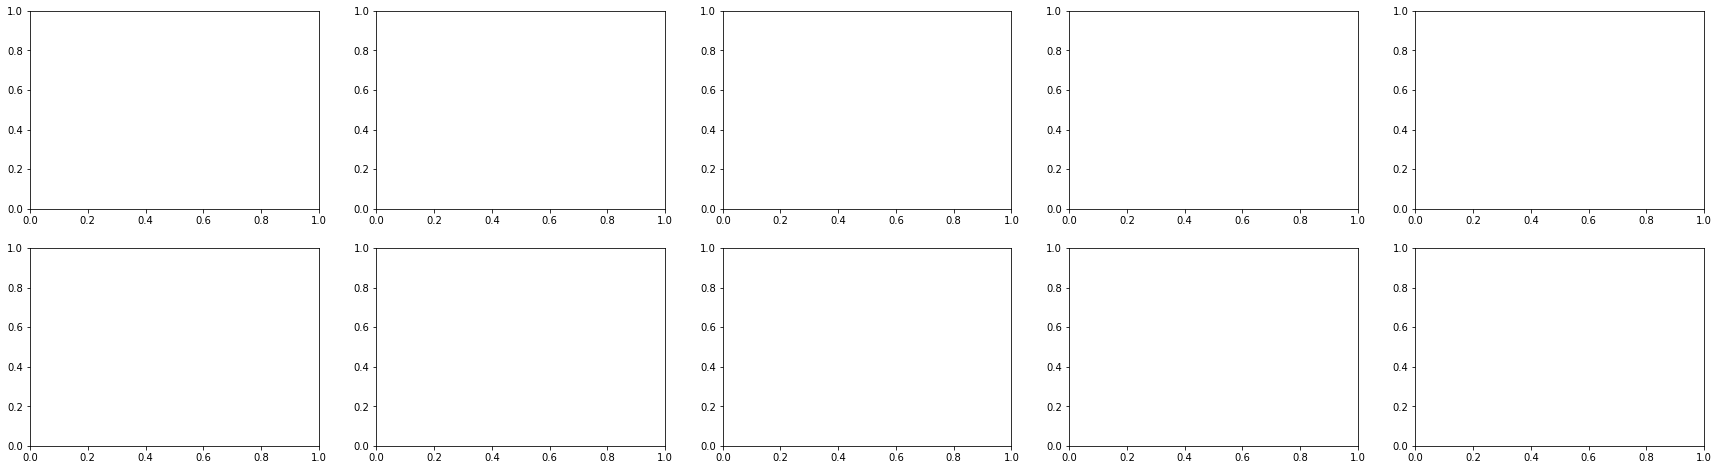

In [10]:
def frame(bright_min, bright_max, reset=0, filename='./data/.hidden_brightness_index.pkl'):
    n_cols = 5
    n_rows = 2
    n_samples = n_cols*n_rows
    if reset:
        index = np.random.permutation(len(x_test))[:n_samples]
        
        with closing(open(filename, 'wb')) as f:
            pkl.dump(index, f)
        # save data
    else:
        # check that file exists
        
        if os.path.isfile(filename):
            with closing(open(filename, 'rb')) as f:
                index = pkl.load(f)
        else:  
            index = np.arange(n_samples)
            with closing(open(filename, 'wb')) as f:
                pkl.dump(index, f)
    #x = np.concatenate([x_test[0:1]]*10, 0)
    x = x_test[index]

    n_cols = 5
    n_rows = 2
    fig, axs = plt.subplots(n_rows, n_cols)
    
    fig.set_figheight(n_rows*fig.get_figheight())
    fig.set_figwidth(n_cols*fig.get_figwidth())
    plt.subplots_adjust(hspace=0.2)  # increase vertical separation
    axs_seq = axs.ravel()

    source_label = y_test[index]
    
    start_time = time.process_time()
    
    upper = get_adv_brightness(decomon_model, x,
                  bright_min=bright_min,
                   bright_max=bright_max,\
                   source_labels=source_label)
    
    end_time = time.process_time()
    
    
    count = 0
    time.sleep(1)
    r_time = "{:.2f}".format(end_time - start_time)
    fig.suptitle('Formal Robustness to Adversarial Examples due to brightness (min={}, max={}) running in {} seconds'.format(bright_min, r_time), fontsize=16)
    for i in range(n_cols):
        for j in range(n_rows):

            ax= axs[j, i]
            ax.imshow(x[count].reshape((28,28)), cmap='Greys')
            robust='ROBUST'
            if upper[count]<0:
                color='green'
            else:
                color='orange'
                robust='MAYBE ROBUST'
        
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            # Create a Rectangle patch
            rect = patches.Rectangle((0,0),27,27,linewidth=3,edgecolor=color,facecolor='none')
            ax.add_patch(rect)
            ax.set_title(robust)
            count+=1
    
            
interact(frame, bright_min = widgets.FloatSlider(value=0.,
                                               min=-0.2,
                                               max=0.,
                                               step=0.0001, continuous_update=False, readout_format='.4f',),
         bright_max = widgets.FloatSlider(value=0.,
                                               min=0.,
                                               max=0.2,
                                               step=0.0001, continuous_update=False, readout_format='.4f',),
         reset = widgets.IntSlider(value=0.,
                                               min=0,
                                               max=1,
                                               step=1, continuous_update=False)
        )

In [10]:
get_adv_brightness(decomon_model_, x_test[0:10],
                  bright_min=[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   bright_max=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],\
                   source_labels=y_test[0:10])

array([-4.36436558, -5.97867537,  7.6925652 , -2.95544797, -5.35754585,
        1.89817333, -0.6429491 ,  3.91962051, -5.65150881, -3.67262793])

In [11]:
get_adv_brightness(decomon_model_, x_test[0:10],
                  bright_min=0.,
                   bright_max=0.1,\
                   source_labels=y_test[0:10])

array([-4.36436558, -5.97867537,  7.6925652 , -2.95544797, -5.35754585,
        1.89817333, -0.6429491 ,  3.91962051, -5.65150881, -3.67262793])

In [14]:
get_adv_brightness(decomon_model_, x_test[0:10],
                  bright_min=0., bright_max=0.1,\
                   source_labels=y_test[0:10], batch_size=3)

array([-4.36436415, -5.97866821,  7.69256425, -2.95544666, -5.35754657,
        1.89817142, -0.6429472 ,  3.91962147, -5.65151119, -3.67263031])

In [16]:
model.predict(x_test[:1]).argmax()

7

In [12]:
y_test_[0]

7

In [13]:
x_test.min()

0.0